<a href="https://colab.research.google.com/github/joshbrx/biomath_model/blob/main/Voronoi_cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __Modelo de células con distribución espacial__

---

Import stantard libraries for plotting and necessary libraries from `SciPy`

In [174]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random 
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.collections import LineCollection

from matplotlib.patches import Polygon

mpl.rcParams['figure.figsize'] = (12,6)

In [175]:
def vpoint_to_xy(vor, index):
    return vor.points[index]

def vpoint_to_region(vor, index):
    return vor.point_region[index]

def region_to_vpoint(vor, index):
    return np.where(vor.point_region == index)[0][0]

In [176]:
def vpoints_to_regions(vor, vpoints):
    regions = []
    for i in vpoints:
        regions.append(vpoint_to_region(vor, i))
    return regions

def regions_to_vpoints(vor, regions):
    vpoints = []
    for i in regions:
        vpoints.append(region_to_vpoint(vor, i))
    return vpoints

Ahora continuamos al definir las fronteras de nuestra superficie. Como queremos que se asemeje a una estructura acinar, simulamos un medio círculo interior y exterior.

\begin{align}
    \alpha(r, \theta) = r,\qquad\ \theta\in{\{0, \pi\}},\quad  r=\{1, 2\}
\end{align}

\begin{align}
    x &= r\cos\theta,\quad &y &= r\sin\theta\\
    \Rightarrow r &= \sqrt{x^2+y^2},\quad &\theta &= \arctan\left(\frac{y}{x}\right)
\end{align}

In [177]:
### parámetros
tol = 0.02; n_space = 150
theta = np.linspace(0, np.pi, n_space);
r = np.array([1.0, 2.0]);

### funciones
alpha_x = lambda r, theta: r*np.cos(theta);
alpha_y = lambda r, theta: r*np.sin(theta);

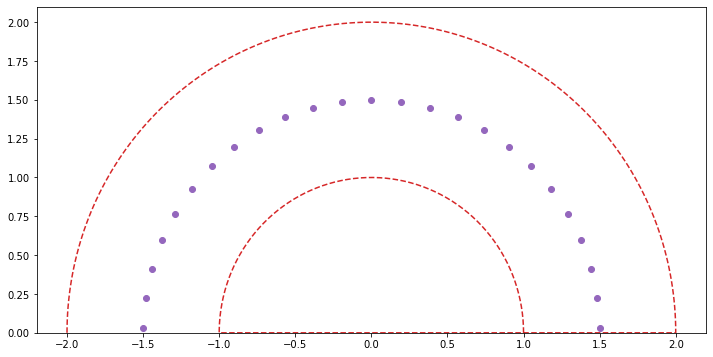

In [178]:
N = 25;
X_border, Y_border = [], []
for i in range(len(r)):
    X_border.append(alpha_x(r[i], theta))
    Y_border.append(alpha_y(r[i], theta))

X_border = np.array(X_border).flatten()
Y_border = np.array(Y_border).flatten()
pts_border = np.array([X_border, Y_border]).T

#----------------------------------------
# r_rand     = np.random.rand(N) * abs(r[-1]-r[0]-2*tol) + r[0] + tol
# theta_rand = np.random.rand(N) * abs(theta[-1]-theta[0]-2*tol) + theta[0] + tol
r_rand = np.ones(N) * 1.5;
theta_rand = np.linspace(tol, np.pi-tol, N);

X_rand = alpha_x(r_rand, theta_rand)
Y_rand = alpha_y(r_rand, theta_rand)
pts_rand = np.array([X_rand, Y_rand]).T

#----------------------------------------
X_base = np.linspace(-r[1], r[1], n_space).flatten()
Y_base = np.zeros(n_space).flatten()-0.1
pts_base = np.array([X_base, Y_base]).T

#----------------------------------------

plt.scatter(X_rand, Y_rand, color="tab:purple")
plt.plot(X_border, Y_border, "--", color="tab:red");
plt.plot(X_base, Y_base, "--", color="tab:red"); 
plt.ylim([0.0,2.1]); plt.show()

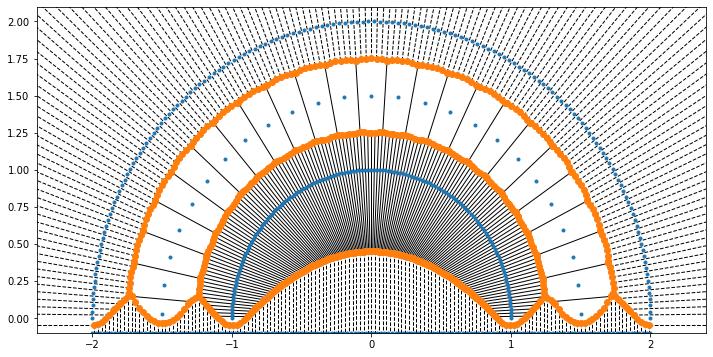

<Figure size 1080x504 with 0 Axes>

In [179]:
total = np.concatenate((pts_rand, pts_border, pts_base))
vor = Voronoi(total)

voronoi_plot_2d(vor)
plt.ylim([-0.1,2.1])
plt.figure(figsize=(15,7))
plt.show()

(-0.1, 2.0)

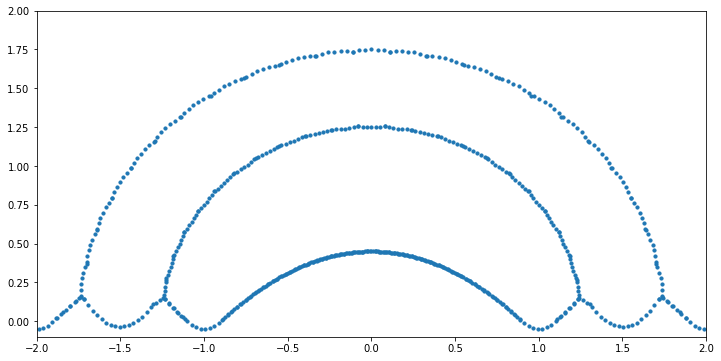

In [180]:
plt.scatter(vor.vertices[:,0], vor.vertices[:,1], s=10)
plt.xlim([-2,2]); plt.ylim([-0.1,2])

*   ###  __Paso $N+1$:__ _Encontrando y discriminando las regiones de Voronoi_



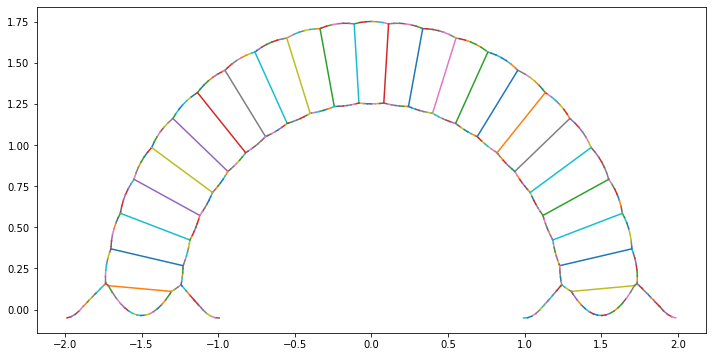

In [181]:
finite_segments = []
for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
    simplex = np.asarray(simplex)
    if np.all(simplex >= 0):
        finite_segments.append(vor.vertices[simplex])

for i in range(len(finite_segments)):
    x_line = finite_segments[i][:,0]
    y_line = finite_segments[i][:,1]
    r_line = (x_line**2 + y_line**2)**(1/2)
    if (np.min(r_line)>= r[0]-tol) and (np.max(r_line)<= r[1]+tol) and (np.min(y_line) >= -0.15):
        plt.plot(x_line, y_line)

In [182]:
def get_polygons(vor):
    Polygons, regions = [], []
    nregions = len(vor.regions)
    for i in range(nregions-1):
        if (not -1 in vor.regions[i]) and (len(vor.regions[i]) >=1):
            x_ = np.array([vor.vertices[k][0] for k in vor.regions[i]])
            y_ = np.array([vor.vertices[k][1] for k in vor.regions[i]])
            r_ = (x_**2+y_**2)**(1/2)
            if (np.min(r_) >= r[0] - tol) and (np.max(r_) <= r[1] + tol):
                polygon = np.array([vor.vertices[k] for k in vor.regions[i]])
                Polygons.append(np.array([*zip(*polygon)]))
                regions.append(i)
    vpoints = regions_to_vpoints(vor, regions)
    Polygons = [x for _,x in sorted(zip(vpoints, Polygons))]

    return Polygons

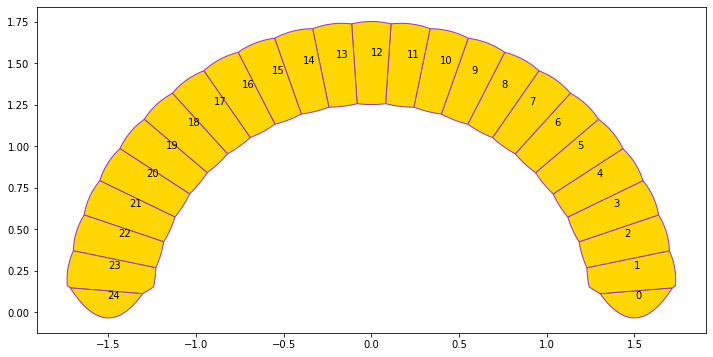

In [183]:
### make up data points
points = np.random.rand(15,2)

### compute Voronoi tesselation
vor = Voronoi(total)

### get Voronoi regions
Polygons = get_polygons(vor)

### visualize Voronoi regions
for i in range(len(Polygons)):
    polygon = Polygons[i]
    X, Y = polygon
    plt.text(np.mean(X), np.mean(Y) + 0.05, f"{i}")
    plt.fill(X, Y, edgecolor="darkorchid", facecolor="gold")
plt.show()

In [184]:
len(Polygons)           # Número de polígonos guardados (coincide con el número de puntos dados)
# x[i] -> Polygons[i][0]
# y[i] -> Polygons[i][1]

25


*   ###  __Paso $N+2$:__ _Calculando el área y el centroide de un polígono_

\begin{align}
    A &= \frac{1}{2}\sum_{i=0}^{N-1} (x_iy_{i+1}-x_{i+1}y_i)
\end{align}

Y para el cálculo de las coordenadas del centro de masas en 2D tenemos las siguientes ecuaciones

\begin{align}
    C_x &= \frac{1}{6A}\sum_{i=0}^{N-1}(x_i+x_{i+1})(x_iy_{i+1}-x_{i+1}y_i) \\
    C_y &= \frac{1}{6A}\sum_{i=0}^{N-1}(y_i+y_{i+1})(x_iy_{i+1}-x_{i+1}y_i)
\end{align}

Para mayor información puede consultar el siguiente enlace: [Calculating the area and centroid of a polygon. By Paul Bourke](https://lexrent.eu/wp-content/uploads/torza/artikel_groep_sub_2_docs/BYZ_3_Polygon-Area-and-Centroid.pdf)

-----

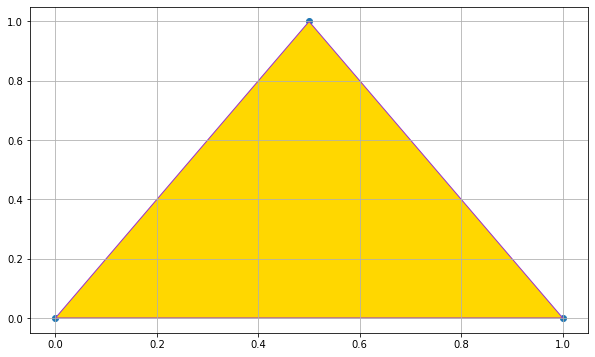

In [185]:
x_prueba = np.array([0,1,0.5])
y_prueba = np.array([0,0,1])

polygon_prueba = np.array([x_prueba, y_prueba])

plt.figure(figsize=(10,6))
plt.scatter(x_prueba, y_prueba); plt.fill(x_prueba, y_prueba, edgecolor="darkorchid", facecolor="gold")
plt.grid()

In [186]:
len(Polygons)

25

In [187]:
def get_area(Polygons, index=None):
    if index == None:
        n_area = Polygons.shape[1]
        X, Y = Polygons
    else:
        n_area = Polygons[index].shape[1]
        X, Y = Polygons[index]
    S = np.empty(n_area)
    
    for i in range(n_area):
        S[i] = X [i]*Y[(i+1) % n_area] - X[(i+1) % n_area]*Y[i]
    return abs((1/2)*np.sum(S))

get_area(polygon_prueba)

0.5

In [188]:
def area_voronoi(Polygons):
    S = np.empty(len(Polygons))

    for i in range(len(S)):
        S[i] = get_area(Polygons, index=i)
    return S

area_voronoi(Polygons)

array([0.04470081, 0.09448322, 0.09571579, 0.09571644, 0.09571733,
       0.09571691, 0.0957161 , 0.0957156 , 0.0957154 , 0.09571551,
       0.09571593, 0.09571666, 0.0957174 , 0.09571666, 0.09571593,
       0.09571551, 0.0957154 , 0.0957156 , 0.0957161 , 0.09571691,
       0.09571733, 0.09571644, 0.09571579, 0.09448322, 0.04470081])

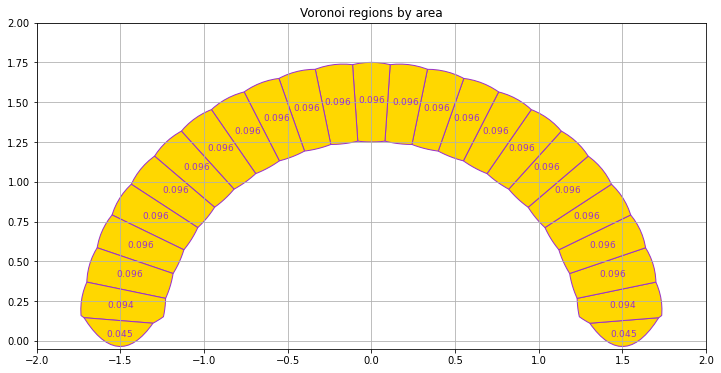

In [189]:
A_vor = area_voronoi(Polygons)

for i in range(len(Polygons)):
    X, Y = Polygons[i]
    num_label = round(A_vor[i], 3)
    plt.text(np.mean(X), np.mean(Y), f'${num_label}$', fontsize=9, horizontalalignment='center', color='darkorchid', fontweight='bold')
    plt.fill(X, Y, edgecolor="darkorchid", facecolor="gold")

plt.title("Voronoi regions by area")
plt.xlim([-2.0, 2.0]); plt.ylim([-0.05, 2.0])
plt.grid()

---

Ahora se calcula el centroide de cada polígono

In [190]:
def get_centroid(Polygons, index=None, tol = 0.02):
    if index == None:
        n_centroid = Polygons.shape[1]
        X, Y = Polygons
        A = get_area(Polygons)
    else:
        n_centroid = Polygons[index].shape[1]
        X, Y = Polygons[index]
        A = get_area(Polygons[index])
    CX, CY = np.empty([2, n_centroid])
    
    
    for i in range(n_centroid):
        CX[i] = (X[i] + X[(i+1) % n_centroid]) * (X[i] * Y[(i+1) % n_centroid] - X[(i+1) % n_centroid]*Y[i])
        CY[i] = (Y[i] + Y[(i+1) % n_centroid]) * (X[i] * Y[(i+1) % n_centroid] - X[(i+1) % n_centroid]*Y[i])
     
    cX, cY = (np.sum(CX), np.sum(CY))/(6*A) 
    if abs(cX - np.mean(X)) > abs(-cX - np.mean(X)):
        cX = -cX
    if abs(cY - np.mean(Y)) > abs(-cY - np.mean(Y)):
        cY = -cY
    return cX, cY

get_centroid(polygon_prueba)

(0.5, 0.3333333333333333)

In [191]:
def centroid_voronoi(Polygons):
    nregions = len(Polygons)
    C = np.empty([2, nregions])
    for i in range(nregions):
        C[:,i] = get_centroid(Polygons, index=i)
    return C

centroid_voronoi(Polygons);

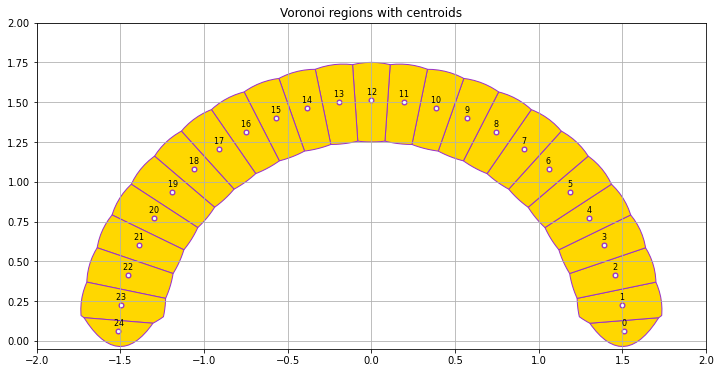

In [192]:
C_vor = centroid_voronoi(Polygons);

fig, ax = plt.subplots();

for i in range(len(Polygons)):
    X, Y = Polygons[i]
    num_label = round(get_area(Polygons[i]), 3)
    plt.text(C_vor[0,i], C_vor[1,i]+0.035, f'${i}$', fontsize=8, horizontalalignment='center', color='black', fontweight='bold')
    ax.fill(X, Y, zorder=-2, edgecolor="darkorchid", facecolor="gold")
ax.scatter(C_vor[0], C_vor[1], color="darkorchid", zorder=1, s=25)
ax.scatter(C_vor[0], C_vor[1], color="azure", zorder=2, s=5)

plt.title("Voronoi regions with centroids")
plt.xlim([-2.0, 2.0]); plt.ylim([-0.05, 2.0])
plt.grid()

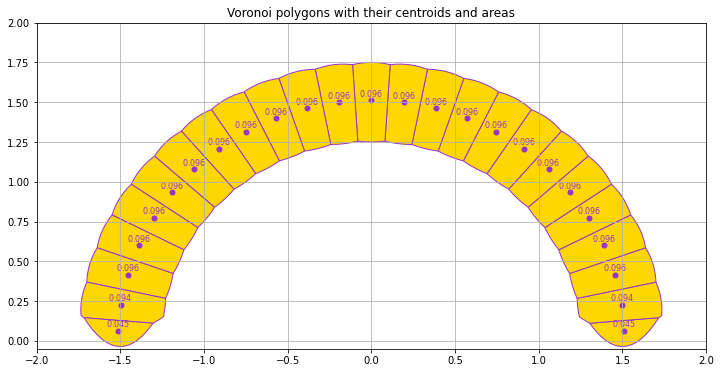

In [193]:
A_vor = area_voronoi(Polygons);
C_vor = centroid_voronoi(Polygons);

for i in range(len(Polygons)):
    X, Y = Polygons[i]
    num_label = round(A_vor[i], 3)
    plt.text(C_vor[0,i], C_vor[1,i]+0.025, f'${num_label}$', fontsize=8, horizontalalignment='center', color='darkorchid', fontweight='bold', zorder=1)
    plt.fill(X, Y, zorder=-2, edgecolor="darkorchid", facecolor="gold")

plt.scatter(C_vor[0], C_vor[1], color="darkorchid", zorder=-1, s=25); ax.scatter(C_vor[0], C_vor[1], color="azure", zorder=0, s=5)
plt.title("Voronoi polygons with their centroids and areas")
plt.xlim([-2.0, 2.0]); plt.ylim([-0.05, 2.0])
plt.grid()

*   ###  __Paso $N+3$:__ _Definiendo las interacciones y evolución del sistema a partir del potencial $V(\vec{x},t)$_

\begin{align}
    V(\vec{r_i}, t) = \frac{K_v}{2}\left(A_i(t)-A_0(t)\right)^2 + \frac{K_c}{2}\big|\vec{r}_i(t) - \vec{r}_{0,i}(t)\big|^2 
\end{align}

donde $A_0 = \sum_{i=1}^N(A_i/N)$

[Cell Patterns Emerge from Coupled Chemical and Physical Fields with Cell Proliferation Dynamics: The Arabidopsis thaliana Root as a Study System](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3642054/)

\begin{align}
    A_{1/2,dona} &= \frac{\pi}{2} \left(r_{max}^2-r_{min}^2\right)\\
    \Rightarrow A_0 &= \lim_{t\to\infty} A_i(t)=\frac{A_{1/2,dona}}{N_{reg}} = \frac{\pi}{2N} \left(r_{max}^2-r_{min}^2\right)
\end{align}

In [194]:
A_dona = (np.pi/2)*(r[1]**2 - r[0]**2)
A_0 = A_dona/len(Polygons)
A_0

0.18849555921538758

In [195]:
K_v, K_c = 1, 1

# (K_v/2)*(A_vor-A_0)**2                # evolución estática
(K_v/2)*(A_vor-np.mean(A_vor))**2;    # evolución dinámica

In [196]:
def dist_vor(pts_vor, C_vor):
    dist, index = [], []
    for i in range(len(pts_vor)):
        s = pts_rand[i].reshape([2,1])
        dist.append(np.min(np.sum((C_vor - s)**2, axis=0)))
        index.append(np.argmin(np.sum((C_vor - s)**2, axis=0)))

    return np.array(dist), np.array(index), 

dist_vor(pts_rand, C_vor)[1]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

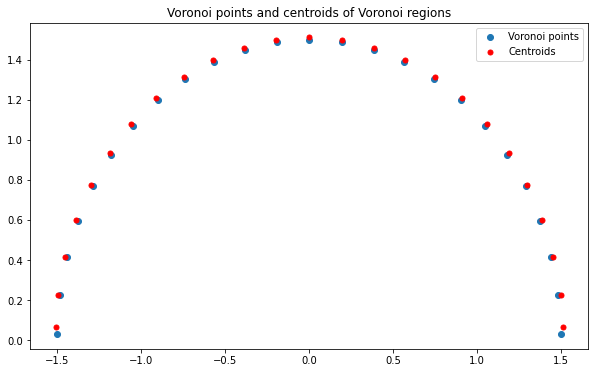

In [197]:
plt.figure(figsize=(10,6))
plt.scatter(pts_rand.T[0],pts_rand.T[1], label="Voronoi points")
plt.scatter(C_vor[0], C_vor[1], color="red", s=25, label="Centroids")
plt.title("Voronoi points and centroids of Voronoi regions"); plt.legend()

In [198]:
K, A_0 = [1, 1], (np.pi/2)*(r[1]**2 - r[0]**2)/len(Polygons)

def potential_vor(K, pts_vor, A_vor, C_vor):
    V = np.empty(len(pts_vor))
    dist, index = dist_vor(pts_vor, C_vor)

    # v1 = ((K[0]/2)*(A_vor-A_0)**2)[index]               # evolución estática
    v1 = ((K[0]/2)*(A_vor-np.mean(A_vor))**2)[index]
    v2 = (K[1]/2)*dist
    return v1 + v2

potential_vor(K, pts_rand, A_vor, C_vor);

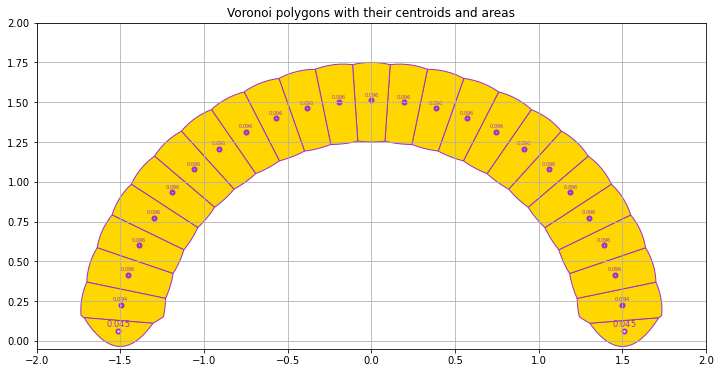

In [199]:
V_vor = potential_vor(K, pts_rand, A_vor, C_vor)

for i in range(len(Polygons)):
    X, Y = Polygons[i]
    num_label = round(A_vor[i], 3)
    plt.text(C_vor[0,i], C_vor[1,i]+0.025, f'${num_label}$', fontsize=np.sqrt(V_vor[i])*100+4, horizontalalignment='center', color='darkorchid', fontweight='bold', zorder=1)
    plt.fill(X, Y, zorder=-2, edgecolor="darkorchid", facecolor="gold")
    plt.scatter(C_vor[0,i], C_vor[1,i], color="azure", zorder=0, s=V_vor[i]*1000)

plt.scatter(C_vor[0], C_vor[1], color="darkorchid", zorder=-1, s=25); 
plt.title("Voronoi polygons with their centroids and areas")
plt.xlim([-2.0, 2.0]); plt.ylim([-0.05, 2.0])
plt.grid()

\begin{align}
    F_x(x_i, t) = &-\frac{K_v}{2}\left[\frac{1}{2}\sum_{m=1}^{M} \frac{(x_i-x_m)\cdot l_{i,m}}{|\vec{r}_i-\vec{r}_m|}\{A_i - A_0\}\right]\\
                  &- K_c(x_i-x_{0,i})\\
    F_y(y_i, t) = &-\frac{K_v}{2}\left[\frac{1}{2}\sum_{m=1}^{M} \frac{(y_i-y_m)\cdot l_{i,m}}{|\vec{r}_i-\vec{r}_m|}\{A_i - A_0\}\right]\\
                  &- K_c(y_i-y_{0,i})  
\end{align}

In [200]:
def get_lines(vor):
    line_segments, line_regions = [], []
    for simplex, pointidx in zip(vor.ridge_vertices, vor.ridge_points):
        if -1 not in simplex:
            pointidx = np.asarray(pointidx)
            simplex = np.asarray(simplex)
            if np.all(pointidx <= len(pts_rand)-1):
                line_segments.append(vor.vertices[simplex])
                line_regions.append(pointidx)
    # line_segments.sort()
    line_segments = np.array(line_segments)
    line_regions = np.array(line_regions)
    return line_segments, line_regions

get_lines(vor)[0], get_lines(vor)[1];

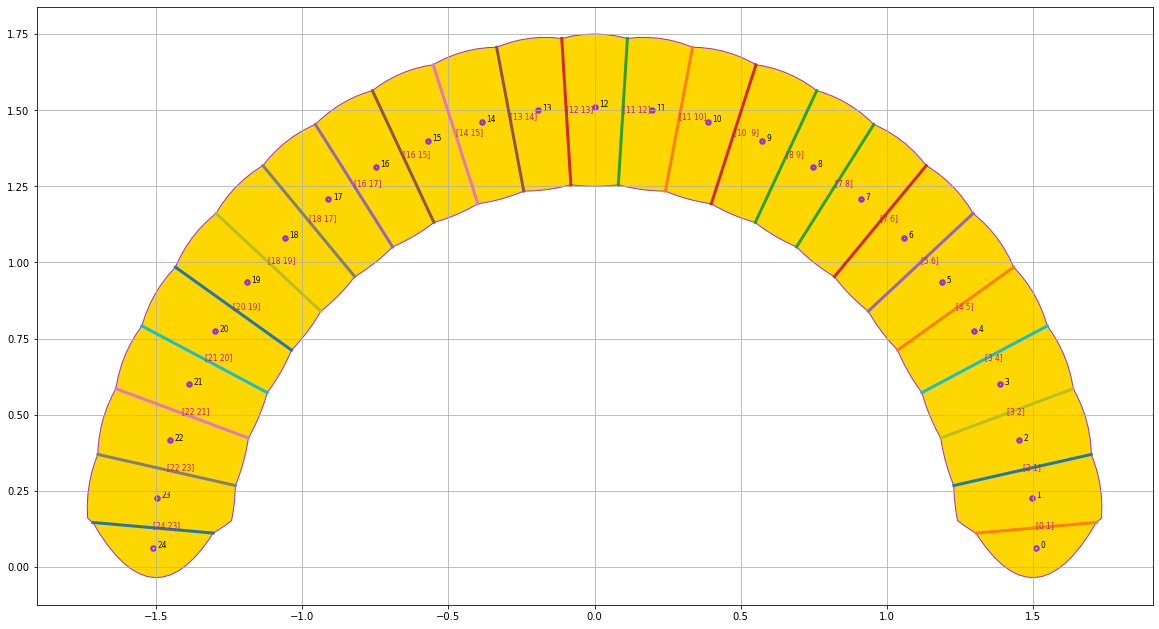

In [201]:
Line_segments, Line_regions = get_lines(vor)
plt.figure(figsize=(20,11))

### Plot shared lines 
for i in range(len(Line_segments)):
    line_segment = Line_segments[i]
    x_line = line_segment[:,0]
    y_line = line_segment[:,1]
    plt.plot(x_line, y_line, linewidth=3)
    plt.text(np.mean(x_line), np.mean(y_line), f"{Line_regions[i]}", color="mediumvioletred", zorder=2, fontsize=7.5)

### Visualize Voronoi regions
for i in range(len(Polygons)):
    X, Y = Polygons[i]
    plt.fill(X, Y, zorder=-2, edgecolor="darkorchid", facecolor="gold")
    plt.text(C_vor[0,i]+0.015, C_vor[1,i], f"{i}", color="black", zorder=0, fontsize=7.5)
    plt.scatter(C_vor[0,i], C_vor[1,i], color="azure", zorder=0, s=V_vor[i]*500)
plt.scatter(C_vor[0], C_vor[1], color="darkorchid", zorder=-1, s=30); 
plt.grid()

In [202]:
def get_dist_dict(vor):
    dist_dict = {}
    Line_segments, Line_regions = get_lines(vor)
    for k in range(len(Line_regions)):
        i, m = sorted(Line_regions[k])
        d = np.sum((Line_segments[k][0]-Line_segments[k][1])**2)
        dist_dict[(i,m)] = d
    return dist_dict

dist_dict = get_dist_dict(vor)

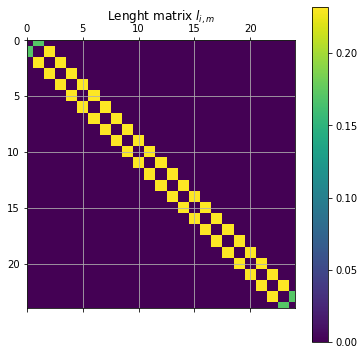

In [203]:
s = (len(Polygons), len(Polygons))
empty_matrix = np.zeros(s)
for k in range(len(Line_regions)):
    i, m = sorted(Line_regions[k])
    d = np.sum((Line_segments[k][0]-Line_segments[k][1])**2)
    empty_matrix[i,m] += d
    empty_matrix[m,i] += d

plt.matshow(empty_matrix);
plt.xlim([0,len(Polygons)-1]); plt.ylim([len(Polygons)-1,0]);
plt.title("Lenght matrix $l_{i,m}$"); plt.colorbar(); plt.grid()

In [206]:
# for key in dist_dict.keys():
#     a, b = key
#     if (a == 7) or (b == 7):
#         print(key, dist_dict[key]) 

In [207]:
K_v, K_c = 1, 1

def F(i, t, Polygons, vor):
    lx, ly = 0, 0
    dist_dict = get_dist_dict(vor)
    for key in dist_dict.keys():
        a, b = key
        if (a == i) or (b == i):
            if a == i: pass
            else: b, a = a, b
            r = vor.points[a]-vor.points[b]
            lx += (dist_dict[key] * r[0] * (get_area(Polygons, index=a)-get_area(Polygons, index=b))) / (np.linalg.norm(r))
            ly += (dist_dict[key] * r[1] * (get_area(Polygons, index=a)-get_area(Polygons, index=b))) / (np.linalg.norm(r))
    lx = (K_v*lx)/4 + K_c*(vor.points[a] - get_centroid(Polygons, index=i, tol = 0.02))[0]
    ly = (K_v*ly)/4 + K_c*(vor.points[a] - get_centroid(Polygons, index=i, tol = 0.02))[1]
    return -lx, -ly

# for i in range(len(Polygons)):
#     print(F(i, 0, Polygons, vor));

(0.9438114926804095, -1.3278122377795)
(0.930882360762698, -1.1647405242807014)
(0.8867369192575146, -0.973107886415081)
(0.8210350294107028, -0.7891460750090369)
(0.7321965446751103, -0.6152509810593942)
(0.6216865036724998, -0.4542555299059377)
(0.49135045107697595, -0.3088460219959077)
(0.34336326048347005, -0.18144668395602406)
(0.18019268208021555, -0.07418137739300833)
(0.004559446507386639, 0.011161537907037798)
(0.0030840615255171167, 0.011656310583298399)
(-0.3722225279259141, 0.1107769567769121)
(-0.5670889056255909, 0.12338715909850616)
(-0.7619552833252677, 0.11077695677691143)
(-0.9535697577938178, 0.07315900362582949)
(-1.1387372577585684, 0.011161537907037571)
(-1.3143704933313978, -0.07418137739300744)
(-1.4775410717346527, -0.18144668395602292)
(-1.6255282623281575, -0.3088460219959084)
(-1.7558643149236814, -0.45425552990593804)
(-1.8663743559262918, -0.6152509810593949)
(-1.955212840661884, -0.7891460750090373)
(-2.0209147305086974, -0.973107886415081)
(-2.0650601720

In [ ]:
def dX(X):
    x, y = X
    vor = Voronoi(np.concatenate((pts_rand, pts_border, pts_base)))
    dx, dy = F(i, t, Polygons, vor)
    # dx = f_x(x, y);
    # dy = f_y(x, y);
    return np.array([dx, dy])
     